# Libraries

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import random
from copy import deepcopy

import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm.auto import tqdm

from timestep_sampling import Uniform, LogitNormal, UShaped
from solvers import euler, midpoint, heun, rk4
from utils import seed_everything
from model import FlowModel2D
from distances import l2_dist

In [2]:
RANDOM_SEED = 0

seed_everything(RANDOM_SEED)

# Model

# Data distribution

In [3]:
seed_everything(RANDOM_SEED)

In [4]:
n_samples = 500

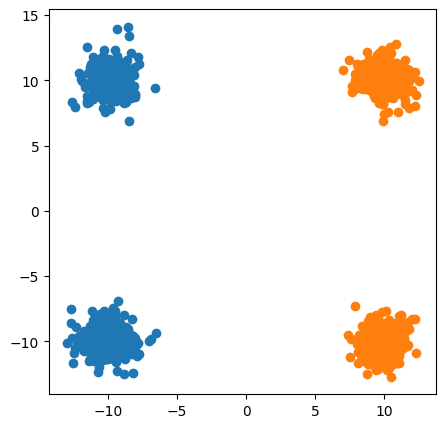

In [5]:
top_left = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, 10]])
bottom_left = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, -10]])

x_0_dataset = torch.cat([top_left, bottom_left])


top_right = torch.randn((n_samples // 2, 2)) + torch.tensor([[+10, 10]])
bottom_right = torch.randn((n_samples // 2, 2)) + torch.tensor([[+10, -10]])

x_1_dataset = torch.cat([top_right, bottom_right])

fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0_dataset[:, 0], x_0_dataset[:, 1])
plt.scatter(x_1_dataset[:, 0], x_1_dataset[:, 1])

# Ordinary Rectified Flow

In [6]:
seed_everything(RANDOM_SEED)

In [7]:
batch_size = 256
n_epochs = 10_000

## Initialize model

In [8]:
reflow_model = FlowModel2D(2, 16, 2)

optimizer = torch.optim.AdamW(
    reflow_model.parameters(),
    5e-4,
)

loss_function = torch.nn.MSELoss()

## Let's train

In [9]:
losses = []

reflow_model.train()
for i in tqdm(range(n_epochs)):
    x_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
    x_1 = x_1_dataset[torch.randint(0, n_samples, (batch_size,))]
    t = torch.sigmoid(torch.randn((batch_size, 1)))

    x_t = t * x_1 + (1 - t) * x_0
    target = x_1 - x_0

    output = reflow_model(x_t, t)

    loss = loss_function(output, target)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/10000 [00:00<?, ?it/s]

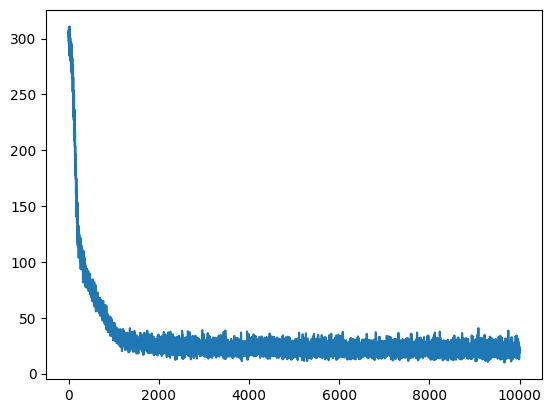

In [10]:
plt.plot(list(range(n_epochs)), losses)

## Inference

In [11]:
reflow_model.eval()

top_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, 10]])
bottom_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, -10]])

x_0 = torch.cat([top_left, bottom_left])

x_t = x_0.clone()
x_ts = [x_t]

NFE = 100
h = 1 / NFE

for t in tqdm(torch.linspace(0, 1, NFE)):
    t = torch.full(size=(n_samples, 1), fill_value=t)
    
    with torch.no_grad():
        output = reflow_model(x_t, t)

    x_t = x_t + h * output

    x_ts.append(x_t)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

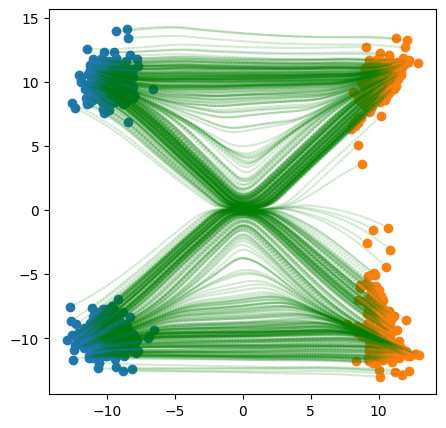

In [12]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1])
plt.scatter(x_t[:, 0], x_t[:, 1])

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step - 1, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()

# Now let's add minibatch OT

In [13]:
seed_everything(RANDOM_SEED)

In [14]:
batch_size = 256
n_epochs = 10_000

In [15]:
ot_reflow_model = FlowModel2D(2, 16, 2)

optimizer = torch.optim.AdamW(
    ot_reflow_model.parameters(),
    5e-4,
)

loss_function = torch.nn.MSELoss()

## Random Sampling

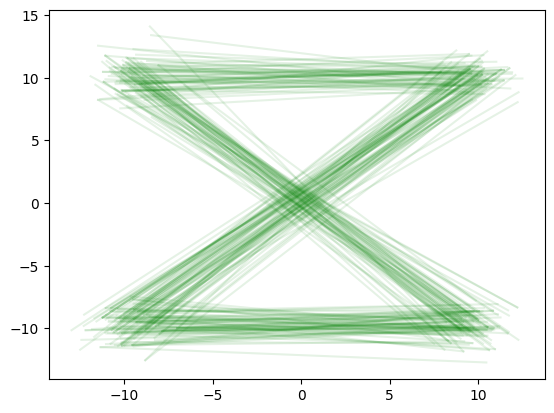

In [16]:
x_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
x_1 = x_1_dataset[torch.randint(0, n_samples, (batch_size,))]

for i in range(batch_size):
    plt.plot(
        [x_0[i, 0].item(), x_1[i, 0].item()], 
        [x_0[i, 1].item(), x_1[i, 1].item()], 
        c="Green",
        alpha=0.1
    )

plt.show()

## OT Sampling

In [17]:
x_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
x_1 = x_1_dataset[torch.randint(0, n_samples, (batch_size,))]

dist = l2_dist(x_0, x_1).numpy()
row_ind, col_ind = scipy.optimize.linear_sum_assignment(dist)
x_1 = x_1[col_ind]

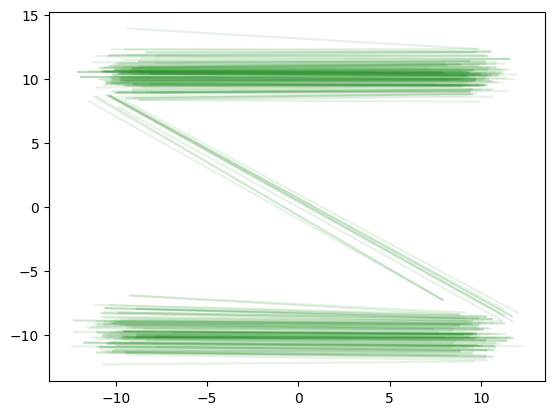

In [18]:
for i in range(batch_size):
    plt.plot(
        [x_0[i, 0].item(), x_1[i, 0].item()], 
        [x_0[i, 1].item(), x_1[i, 1].item()], 
        c="Green",
        alpha=0.1
    )

plt.show()

## Let's train

In [19]:
losses = []

ot_reflow_model.train()
for i in tqdm(range(n_epochs)):
    x_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
    x_1 = x_1_dataset[torch.randint(0, n_samples, (batch_size,))]

    dist = l2_dist(x_0, x_1)
    plan = scipy.optimize.linear_sum_assignment(dist)[1]
    x_1 = x_1[plan]
    
    t = torch.sigmoid(torch.randn((batch_size, 1)))

    x_t = t * x_1 + (1 - t) * x_0
    target = x_1 - x_0

    output = ot_reflow_model(x_t, t)

    loss = loss_function(output, target)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/10000 [00:00<?, ?it/s]

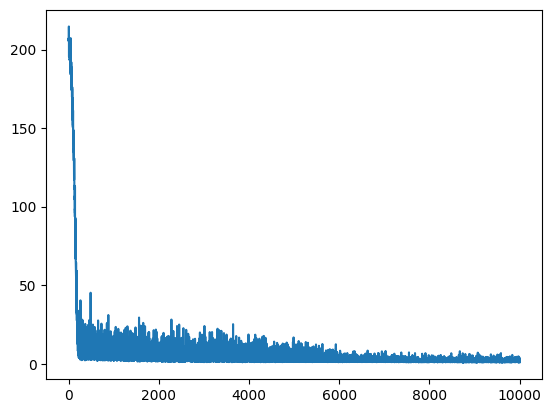

In [20]:
plt.plot(list(range(n_epochs)), losses)

In [21]:
ot_reflow_model.eval()

top_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, 10]])
bottom_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, -10]])

x_0 = torch.cat([top_left, bottom_left])

x_t = x_0.clone()
x_ts = [x_t]

NFE = 100
h = 1 / NFE

for t in tqdm(torch.linspace(0, 1, NFE)):
    t = torch.full(size=(n_samples, 1), fill_value=t)
    
    with torch.no_grad():
        output = ot_reflow_model(x_t, t)

    x_t = x_t + h * output

    x_ts.append(x_t)

  0%|          | 0/100 [00:00<?, ?it/s]

## Inference

  0%|          | 0/500 [00:00<?, ?it/s]

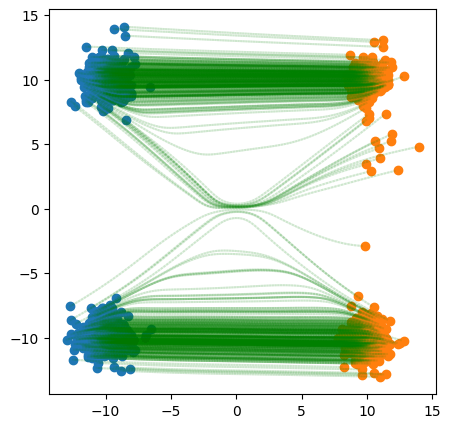

In [22]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1])
plt.scatter(x_t[:, 0], x_t[:, 1])

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step - 1, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()

# Reflow 2 from Reflow 1

In [23]:
seed_everything(RANDOM_SEED)

In [24]:
batch_size = 256
n_epochs = 1_000

In [25]:
teacher_model = deepcopy(reflow_model)
reflow_2_model = deepcopy(reflow_model)

optimizer = torch.optim.AdamW(
    reflow_2_model.parameters(),
    5e-4,
)

loss_function = torch.nn.MSELoss()

In [26]:
def teacher_sample_z_1(model, x_0):
    model.eval()
    x_t = x_0.clone()

    NFE = 100
    h = 1 / NFE
    
    for t in torch.linspace(0, 1, NFE):
        t = torch.full(size=(x_0.shape[0], 1), fill_value=t)
        
        with torch.no_grad():
            output = model(x_t, t)
    
        x_t = x_t + h * output
    
    return x_t

## Let's train

In [27]:
losses = []

reflow_2_model.train()
for i in tqdm(range(n_epochs)):
    z_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
    z_1 = teacher_sample_z_1(teacher_model, z_0)
    
    t = torch.sigmoid(torch.randn((batch_size, 1)))

    z_t = t * z_1 + (1 - t) * z_0
    target = z_1 - z_0

    output = reflow_2_model(z_t, t)

    loss = loss_function(output, target)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

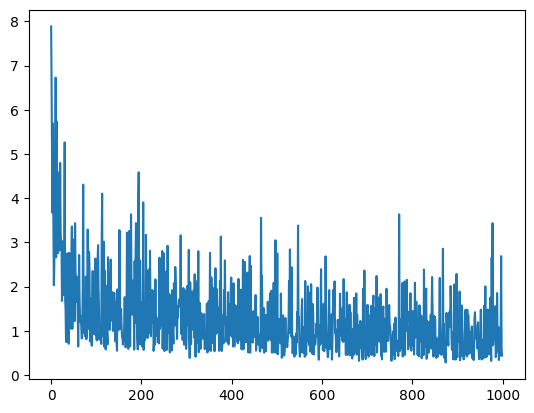

In [28]:
plt.plot(list(range(n_epochs)), losses)

## Inference

In [29]:
reflow_2_model.eval()

top_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, 10]])
bottom_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, -10]])

x_0 = torch.cat([top_left, bottom_left])

x_t = x_0.clone()
x_ts = [x_t]

NFE = 100
h = 1 / NFE

for t in tqdm(torch.linspace(0, 1, NFE)):
    t = torch.full(size=(n_samples, 1), fill_value=t)
    
    with torch.no_grad():
        output = reflow_2_model(x_t, t)

    x_t = x_t + h * output

    x_ts.append(x_t)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

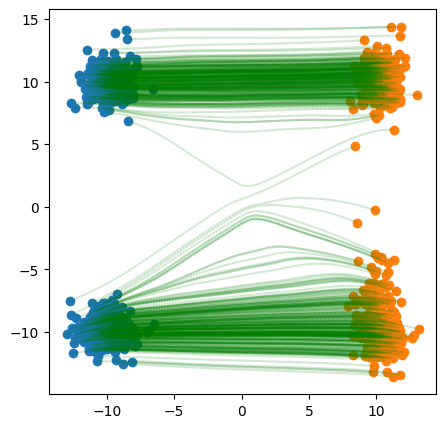

In [30]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1])
plt.scatter(x_t[:, 0], x_t[:, 1])

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()

# Reflow 2 form OT Reflow 1

In [31]:
seed_everything(RANDOM_SEED)

In [32]:
batch_size = 256
n_epochs = 1_000

In [33]:
teacher_model = deepcopy(ot_reflow_model)
ot_reflow_2_model = deepcopy(ot_reflow_model)

optimizer = torch.optim.AdamW(
    ot_reflow_2_model.parameters(),
    5e-4,
)

loss_function = torch.nn.MSELoss()

## Let's train

In [34]:
losses = []

ot_reflow_2_model.train()
for i in tqdm(range(n_epochs)):
    z_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
    z_1 = teacher_sample_z_1(teacher_model, z_0)
    
    t = torch.sigmoid(torch.randn((batch_size, 1)))

    z_t = t * z_1 + (1 - t) * z_0
    target = z_1 - z_0

    output = ot_reflow_2_model(z_t, t)

    loss = loss_function(output, target)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

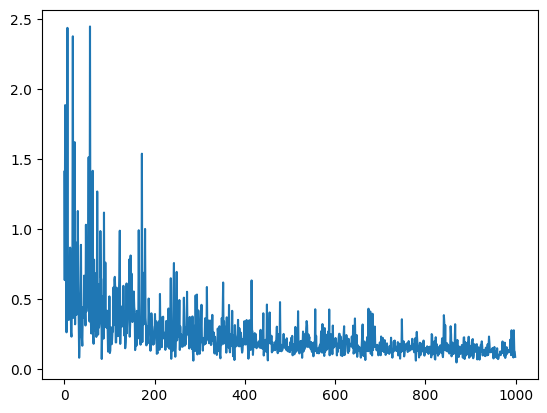

In [35]:
plt.plot(list(range(n_epochs)), losses)

## Inference

In [36]:
ot_reflow_2_model.eval()

top_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, 10]])
bottom_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, -10]])

x_0 = torch.cat([top_left, bottom_left])

x_t = x_0.clone()
x_ts = [x_t]

NFE = 100
h = 1 / NFE

for t in tqdm(torch.linspace(0, 1, NFE)):
    t = torch.full(size=(n_samples, 1), fill_value=t)
    
    with torch.no_grad():
        output = ot_reflow_2_model(x_t, t)

    x_t = x_t + h * output

    x_ts.append(x_t)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

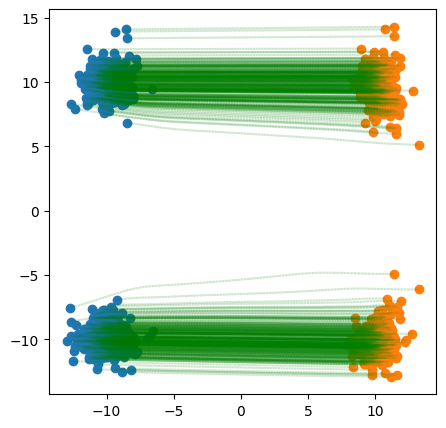

In [37]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1])
plt.scatter(x_t[:, 0], x_t[:, 1])

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()

# U-shaped Timestep Distribution

In [38]:
seed_everything(RANDOM_SEED)

In [39]:
batch_size = 256
n_epochs = 1_000

In [40]:
ushaped_dist = UShaped(a=4)

In [41]:
teacher_model = deepcopy(ot_reflow_model)
ot_reflow_2_u_model = deepcopy(ot_reflow_model)

optimizer = torch.optim.AdamW(
    ot_reflow_2_u_model.parameters(),
    5e-4,
)

loss_function = torch.nn.MSELoss()

## Let's train

In [42]:
losses = []

ot_reflow_2_u_model.train()
for i in tqdm(range(n_epochs)):
    z_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
    z_1 = teacher_sample_z_1(teacher_model, z_0)
    
    t = ushaped_dist.sample(batch_size).unsqueeze(dim=1)

    z_t = t * z_1 + (1 - t) * z_0
    target = z_1 - z_0

    output = ot_reflow_2_u_model(z_t, t)

    loss = loss_function(output, target)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

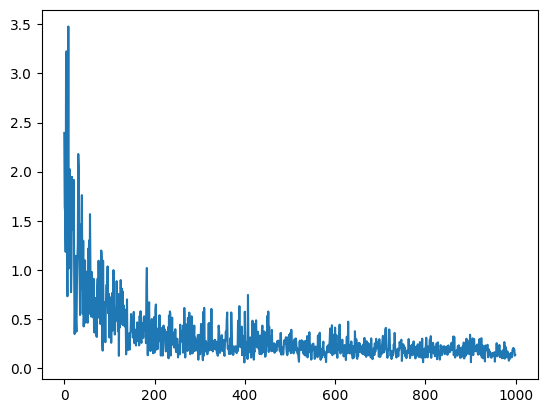

In [43]:
plt.plot(list(range(n_epochs)), losses)

## Inference

In [44]:
ot_reflow_2_u_model.eval()

top_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, 10]])
bottom_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, -10]])

x_0 = torch.cat([top_left, bottom_left])

x_t = x_0.clone()
x_ts = [x_t]

NFE = 5
h = 1 / NFE

for t in tqdm(torch.linspace(0, 1, NFE)):
    t = torch.full(size=(n_samples, 1), fill_value=t)
    
    with torch.no_grad():
        output = ot_reflow_2_u_model(x_t, t)

    x_t = x_t + h * output

    x_ts.append(x_t)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

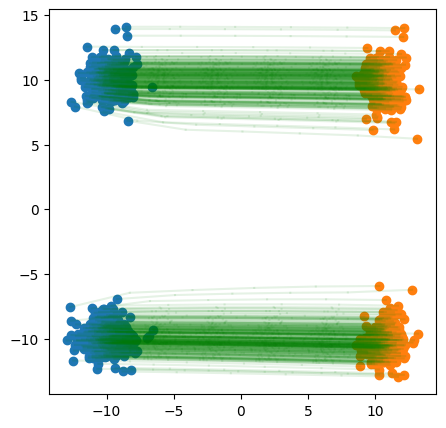

In [45]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1])
plt.scatter(x_t[:, 0], x_t[:, 1])

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()

In [46]:
seed_everything(RANDOM_SEED)

In [47]:
batch_size = 256
n_epochs = 1_000

In [48]:
teacher_model = deepcopy(ot_reflow_model)
ot_reflow_2_solver_distill_model = deepcopy(ot_reflow_model)

optimizer = torch.optim.AdamW(
    ot_reflow_2_solver_distill_model.parameters(),
    5e-4, 
)

loss_function = torch.nn.MSELoss()

## Let's train

In [49]:
losses = []

ot_reflow_2_solver_distill_model.train()

for TRAIN_NFE in [10, 5, 4, 3, 2, 1]:
    h = (1 / TRAIN_NFE)
    
    for i in tqdm(range(n_epochs)):
        z_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
        z_1 = teacher_sample_z_1(teacher_model, z_0)
    
        z_t = z_0
    
        straightness_loss = 0
    
        for t in torch.linspace(0, 1 - h, TRAIN_NFE):
            t = torch.full(size=(batch_size, 1), fill_value=t)
            z_t = z_t + h * ot_reflow_2_solver_distill_model(z_t, t)
    
            expected_z_t = (t + h) * z_1 + (1 - (t + h)) * z_0
            
            straightness_loss += (1 - t[0]) * loss_function(z_t, expected_z_t)
        
        loss = straightness_loss
    
        losses.append(loss.item())
    
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

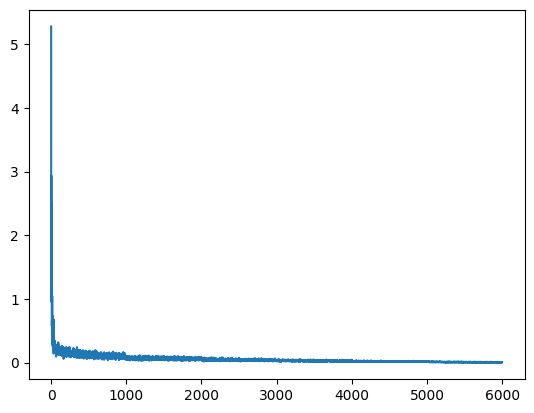

In [50]:
plt.plot(list(range(n_epochs * 6)), losses)

## Inference

In [71]:
ot_reflow_2_solver_distill_model.eval()

top_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, 10]])
bottom_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, -10]])

x_0 = torch.cat([top_left, bottom_left])

x_t = x_0.clone()
x_ts = [x_t]

NFE = 5
h = 1 / NFE

for t in tqdm(torch.linspace(0, 1, NFE)):
    t = torch.full(size=(n_samples, 1), fill_value=t)
    
    with torch.no_grad():
        output = ot_reflow_2_solver_distill_model(x_t, t)

    x_t = x_t + h * output

    x_ts.append(x_t)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

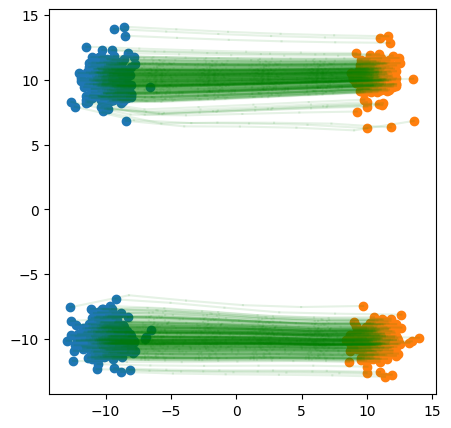

In [72]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1])
plt.scatter(x_t[:, 0], x_t[:, 1])

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()

In [54]:
seed_everything(RANDOM_SEED)

In [55]:
batch_size = 256
n_epochs = 1_000

In [56]:
teacher_model = deepcopy(ot_reflow_model)
ot_reflow_2_solver_distill_forcing_model = deepcopy(ot_reflow_model)

optimizer = torch.optim.AdamW(
    ot_reflow_2_solver_distill_forcing_model.parameters(),
    5e-4, 
)

loss_function = torch.nn.MSELoss()

In [57]:
losses = []

ot_reflow_2_solver_distill_forcing_model.train()

for TRAIN_NFE in [10, 5, 4, 3, 2, 1]:
    h = (1 / TRAIN_NFE)
    
    for i in tqdm(range(n_epochs)):
        z_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
        z_1 = teacher_sample_z_1(teacher_model, z_0)
        
        straightness_loss = 0
        
        for t in torch.linspace(0, 1 - h, TRAIN_NFE):
            t = torch.full(size=(batch_size, 1), fill_value=t)

            z_t = t * z_1 + (1 - t) * z_0
            
            next_predicted_z_t = z_t + h * ot_reflow_2_solver_distill_forcing_model(z_t, t)
    
            expected_z_t = (t + h) * z_1 + (1 - (t + h)) * z_0
            
            straightness_loss += (1 - t[0]) * loss_function(next_predicted_z_t, expected_z_t)
        
        loss = straightness_loss
    
        losses.append(loss.item())
    
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

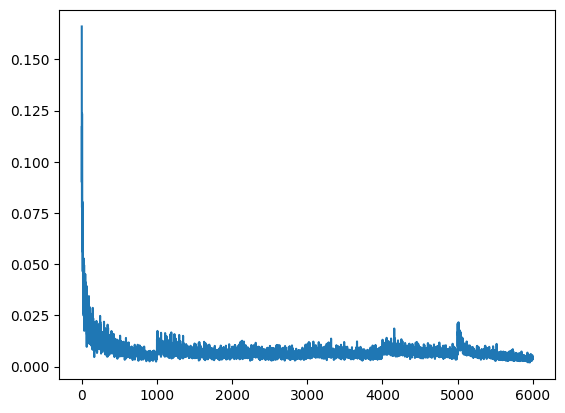

In [58]:
plt.plot(list(range(n_epochs * 6)), losses)

In [69]:
ot_reflow_2_solver_distill_forcing_model.eval()

top_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, 10]])
bottom_left_inference = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, -10]])

x_0 = torch.cat([top_left, bottom_left])

x_t = x_0.clone()
x_ts = [x_t]

NFE = 1
h = 1 / NFE

for t in tqdm(torch.linspace(0, 1, NFE)):
    t = torch.full(size=(n_samples, 1), fill_value=t)
    
    with torch.no_grad():
        output = ot_reflow_2_solver_distill_forcing_model(x_t, t)

    x_t = x_t + h * output

    x_ts.append(x_t)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

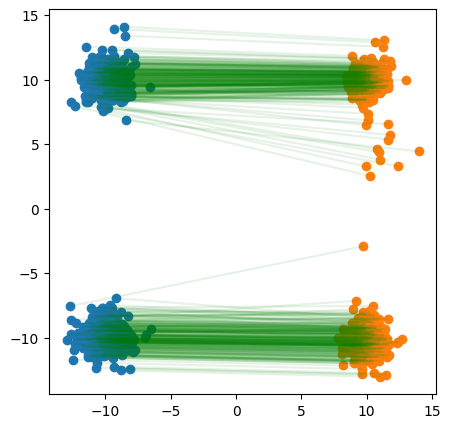

In [70]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1])
plt.scatter(x_t[:, 0], x_t[:, 1])

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()